# Analysis of Environment Aloft

This notebook analyzes the environment above clouds at their birth time, relating it to cloud lifetime and maximum height.
We focus on full lifecycle clouds (no merges/splits) and examine how the environment aloft (RH, moisture, stability, shear) correlates with cloud development.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr

# Plotting style
sns.set_context("talk")
sns.set_style("ticks")

# Constants
nc_file = "../cloud_results.nc"
dt = 60.0  # seconds per timestep
dz = 25.0  # meters (vertical grid spacing)

# --- Filtering Configuration ---
min_lifetime_mins = 10       # Minimum lifetime in minutes
filter_mergers_splits = True # If True, exclude clouds that merge or split (isolated only)
min_max_size = 0             # Minimum max size (voxels) required for a track

min_lifetime_steps = int(min_lifetime_mins * 60 / dt)
# Ensure at least 1 step to avoid indexing errors
if min_lifetime_steps < 1:
    min_lifetime_steps = 1

print(f"Minimum lifetime steps: {min_lifetime_steps}")
print(f"Filter Mergers/Splits: {filter_mergers_splits}")
print(f"Minimum Max Size: {min_max_size}")

Minimum lifetime steps: 1


### Data Loading
**Physics:** Loads tracks and environmental profiles (RH, $N^2$, shear) from the column directly above cloud top at birth.

In [ ]:
def load_data(nc_path):
    with Dataset(nc_path, 'r') as ds:
        # Load track info
        valid_track = ds.variables['valid_track'][:]
        merges_count = np.ma.filled(ds.variables['merges_count'][:], 0)
        splits_count = np.ma.filled(ds.variables['splits_count'][:], 0)
        
        # Load cloud properties
        size = np.ma.filled(ds.variables['size'][:], np.nan)
        max_height = np.ma.filled(ds.variables['max_height'][:], np.nan)
        
        # Load age variable for lifetime calculation
        # Shape: (track, time)
        age = np.ma.filled(ds.variables['age'][:], np.nan)
        
        # Load environment aloft variables
        # Shape: (track, time, height_aloft)
        env_aloft_rh = np.ma.filled(ds.variables['env_aloft_rh'][:], np.nan)
        env_aloft_qt_diff = np.ma.filled(ds.variables['env_aloft_qt_diff'][:], np.nan)
        env_aloft_n2 = np.ma.filled(ds.variables['env_aloft_n2'][:], np.nan)
        env_aloft_shear = np.ma.filled(ds.variables['env_aloft_shear'][:], np.nan)
        
    return {
        'valid_track': valid_track,
        'merges_count': merges_count,
        'splits_count': splits_count,
        'size': size,
        'max_height': max_height,
        'age': age,
        'env_aloft_rh': env_aloft_rh,
        'env_aloft_qt_diff': env_aloft_qt_diff,
        'env_aloft_n2': env_aloft_n2,
        'env_aloft_shear': env_aloft_shear
    }

data = load_data(nc_file)
print("Data loaded.")

Data loaded.


### Data Filtering
**Physics:** Filters the dataset based on lifecycle properties.
*   **Valid Track:** Always requires a complete lifecycle (start to finish recorded, no edge artifacts).
*   **Mergers/Splits:** Configurable. Can restrict to isolated clouds (no interaction) or include complex tracks.
*   **Size/Duration:** Filters for minimum development to remove noise.

In [ ]:
# Filter Data

# 1. Calculate lifetime using the 'age' variable
# The 'age' variable tracks the age of the cloud at each timestep.
# The maximum age reached by a track represents its total lifetime.
# Note: age is in seconds.
max_age_seconds = np.nanmax(data['age'], axis=1)
lifetime_mins = max_age_seconds / 60.0
lifetime_steps = (max_age_seconds / dt).astype(int)

# 2. Identify birth time (first index where size is not NaN)
# We can use argmax on the boolean mask ~np.isnan(size) to find the first True
# Note: For tracks with all NaNs (lifetime=0), argmax returns 0. These are filtered out by min_lifetime.
birth_indices = np.argmax(~np.isnan(data['size']), axis=1)

# 3. Calculate Max Size per track
# Used for size filtering
max_size_per_track = np.nanmax(data['size'], axis=1)

# 4. Construct Filter Masks

# A. Valid track (complete lifecycle, not tainted by domain edges)
is_valid = data['valid_track'] == 1

# B. Merger/Split Filter
# If filter_mergers_splits is True, we require 0 merges and 0 splits.
# Otherwise, we allow them (mask is all True).
if filter_mergers_splits:
    no_merges = np.sum(data['merges_count'], axis=1) == 0
    no_splits = np.sum(data['splits_count'], axis=1) == 0
    interaction_mask = no_merges & no_splits
else:
    interaction_mask = np.ones_like(is_valid, dtype=bool)

# C. Minimum Lifetime
long_enough = lifetime_steps >= min_lifetime_steps

# D. Minimum Size
big_enough = max_size_per_track >= min_max_size

# Combine all masks
clean_mask = is_valid & interaction_mask & long_enough & big_enough

print(f"Total tracks: {len(lifetime_steps)}")
print(f"  - Valid (full lifecycle): {np.sum(is_valid)}")
print(f"  - Interaction Filter (Pure={filter_mergers_splits}): {np.sum(interaction_mask)}")
print(f"  - Duration >= {min_lifetime_mins} min: {np.sum(long_enough)}")
print(f"  - Size >= {min_max_size}: {np.sum(big_enough)}")
print(f"Final clean selection: {np.sum(clean_mask)}")

# Apply mask
selected_indices = np.where(clean_mask)[0]

# Extract birth-time profiles for selected clouds
# We need to index (track, time, height_aloft)
# Advanced indexing: data[track_idx, birth_time_idx, :]

birth_times = birth_indices[selected_indices]

# Extract variables
sel_lifetime_mins = lifetime_mins[selected_indices]
# Max height is time-dependent, we want the max over the lifetime
# max_height variable in NC is (track, time). We want the global max for each track.
sel_max_height = np.nanmax(data['max_height'][selected_indices], axis=1)

# Extract profiles
# Shape: (N_selected, N_levels)
# Extract the environment at the moment of birth.
# 'birth_times' contains the time index of the first valid cloud size for each selected track.
sel_env_rh = data['env_aloft_rh'][selected_indices, birth_times, :]
sel_env_qt = data['env_aloft_qt_diff'][selected_indices, birth_times, :]
sel_env_n2 = data['env_aloft_n2'][selected_indices, birth_times, :]
sel_env_shear = data['env_aloft_shear'][selected_indices, birth_times, :]

# Define z_above coordinates
n_levels = sel_env_rh.shape[1]
z_above = (np.arange(n_levels) + 1) * dz

print(f"Extracted profiles for {len(selected_indices)} clouds.")
print(f"z_above levels: {z_above}")

Total tracks: 1000
Valid tracks: 729
Untainted (no merge/split): 573
Long enough (>= 1 min): 1000
Final clean selection: 415
Extracted profiles for 415 clouds.
z_above levels: [  25.   50.   75.  100.  125.  150.  175.  200.  225.  250.  275.  300.
  325.  350.  375.  400.  425.  450.  475.  500.  525.  550.  575.  600.
  625.  650.  675.  700.  725.  750.  775.  800.  825.  850.  875.  900.
  925.  950.  975. 1000.]


### Profiles vs. Lifetime
**Physics:** Checks for pre-conditioning. Do longer-lived shallow cumuli form under moister, less stable, or lower-shear conditions aloft?

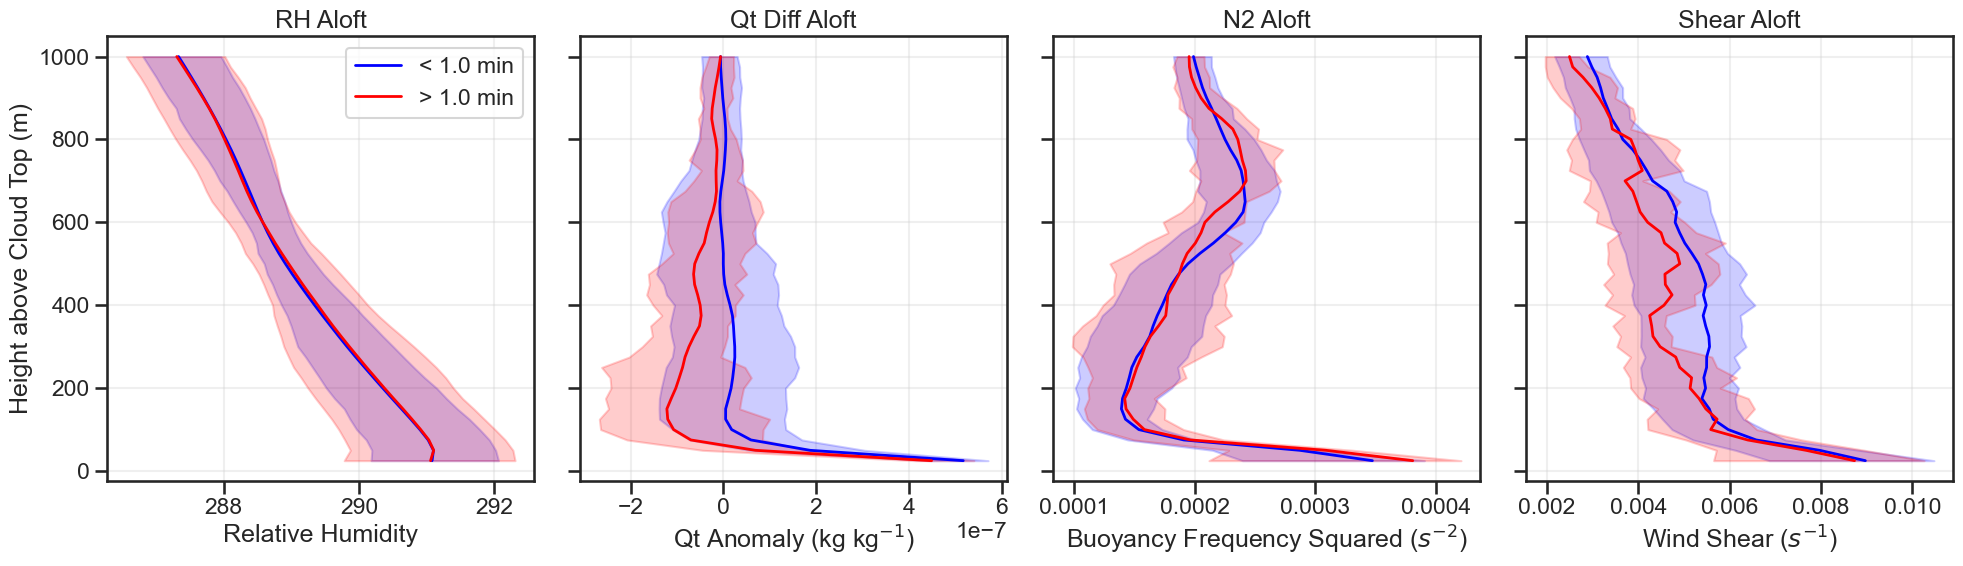

In [ ]:
# --- Plot 1: Profiles conditioned on Lifetime ---

# Define groups by quartiles
q1 = np.percentile(sel_lifetime_mins, 25)
q2 = np.percentile(sel_lifetime_mins, 50)
q3 = np.percentile(sel_lifetime_mins, 75)

groups = []
labels = []
colors = ['blue', 'green', 'orange', 'red']

# Group 1: < 25%
mask1 = sel_lifetime_mins <= q1
groups.append(mask1)
labels.append(f"< {q1:.1f} min")

# Group 2: 25-50%
mask2 = (sel_lifetime_mins > q1) & (sel_lifetime_mins <= q2)
groups.append(mask2)
labels.append(f"{q1:.1f}-{q2:.1f} min")

# Group 3: 50-75%
mask3 = (sel_lifetime_mins > q2) & (sel_lifetime_mins <= q3)
groups.append(mask3)
labels.append(f"{q2:.1f}-{q3:.1f} min")

# Group 4: > 75%
mask4 = sel_lifetime_mins > q3
groups.append(mask4)
labels.append(f"> {q3:.1f} min")

# Define variables with physical units
variable_info = {
    'RH Aloft': (sel_env_rh, 'Relative Humidity'),
    'Qt Diff Aloft': (sel_env_qt, 'Qt Anomaly (kg kg$^{-1}$)'),
    'N2 Aloft': (sel_env_n2, 'Buoyancy Frequency Squared ($s^{-2}$)'),
    'Shear Aloft': (sel_env_shear, 'Wind Shear ($s^{-1}$)')
}

fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True)
axes = axes.flatten()

for i, (var_name, (var_data, unit_label)) in enumerate(variable_info.items()):
    ax = axes[i]
    for j, mask in enumerate(groups):
        if np.sum(mask) == 0: continue
        
        # Compute mean and IQR
        subset = var_data[mask, :]
        mean_prof = np.nanmean(subset, axis=0)
        p25_prof = np.nanpercentile(subset, 25, axis=0)
        p75_prof = np.nanpercentile(subset, 75, axis=0)
        
        ax.plot(mean_prof, z_above, label=labels[j], color=colors[j], linewidth=2)
        ax.fill_betweenx(z_above, p25_prof, p75_prof, color=colors[j], alpha=0.2)
        
    ax.set_title(var_name)
    ax.set_xlabel(unit_label)
    if i == 0:
        ax.set_ylabel("Height above Cloud Top (m)")
        ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Profiles vs. Max Height
**Physics:** Growth potential. Does the local environment above the cloud top determine which shallow clouds deepen vs. those that remain stunted?

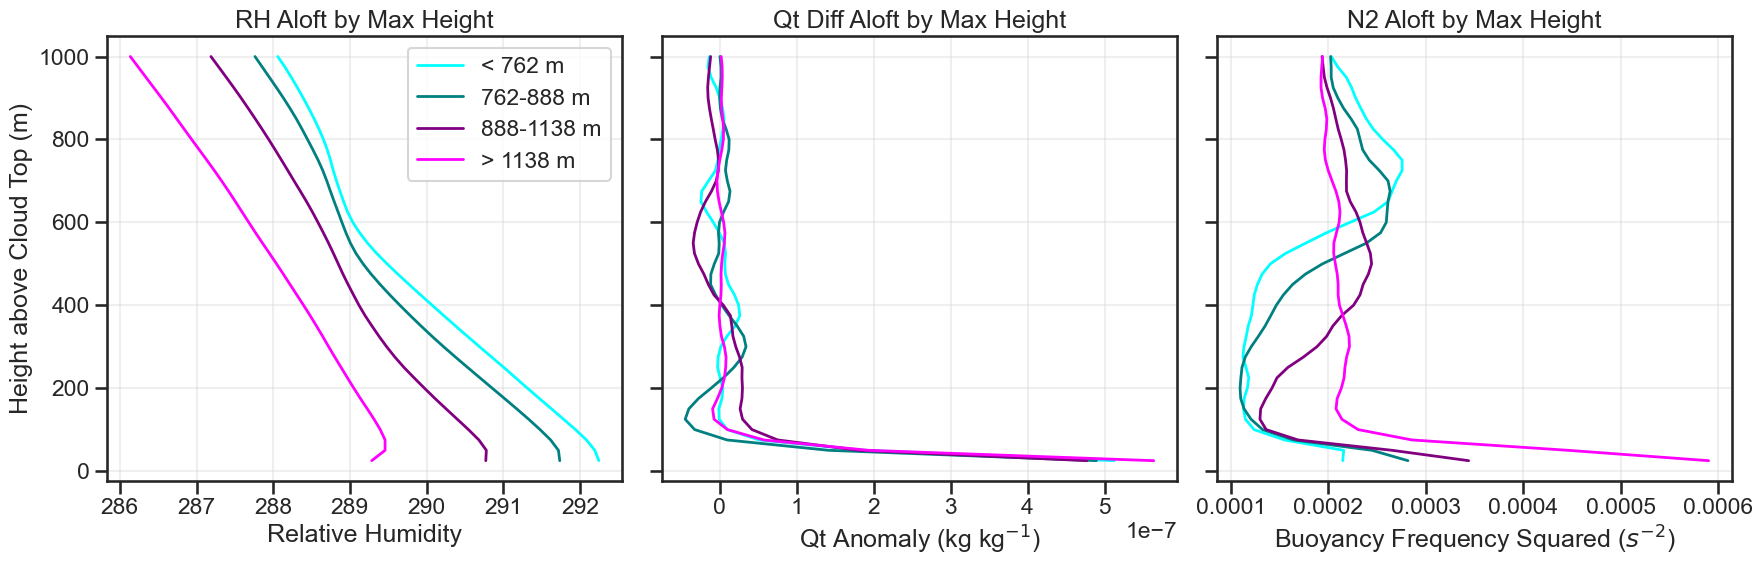

In [ ]:
# --- Plot 2: Profiles conditioned on Max Height ---

# Define groups by quartiles of max height
h_q1 = np.percentile(sel_max_height, 25)
h_q2 = np.percentile(sel_max_height, 50)
h_q3 = np.percentile(sel_max_height, 75)

h_groups = []
h_labels = []
h_colors = ['cyan', 'teal', 'purple', 'magenta']

# Group 1: Shallow
mask1 = sel_max_height <= h_q1
h_groups.append(mask1)
h_labels.append(f"< {h_q1:.0f} m")

# Group 2: Medium-Shallow
mask2 = (sel_max_height > h_q1) & (sel_max_height <= h_q2)
h_groups.append(mask2)
h_labels.append(f"{h_q1:.0f}-{h_q2:.0f} m")

# Group 3: Medium-Deep
mask3 = (sel_max_height > h_q2) & (sel_max_height <= h_q3)
h_groups.append(mask3)
h_labels.append(f"{h_q2:.0f}-{h_q3:.0f} m")

# Group 4: Deep
mask4 = sel_max_height > h_q3
h_groups.append(mask4)
h_labels.append(f"> {h_q3:.0f} m")

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
axes = axes.flatten()

# Plot only RH, Qt Diff, N2 as requested
vars_to_plot = ['RH Aloft', 'Qt Diff Aloft', 'N2 Aloft']

for i, var_name in enumerate(vars_to_plot):
    ax = axes[i]
    # Use variable_info from previous cell
    var_data, unit_label = variable_info[var_name]
    
    for j, mask in enumerate(h_groups):
        if np.sum(mask) == 0: continue
        
        subset = var_data[mask, :]
        mean_prof = np.nanmean(subset, axis=0)
        
        ax.plot(mean_prof, z_above, label=h_labels[j], color=h_colors[j], linewidth=2)
        
    ax.set_title(f"{var_name} by Max Height")
    ax.set_xlabel(unit_label)
    if i == 0:
        ax.set_ylabel("Height above Cloud Top (m)")
        ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Layer Indices vs. Outcomes
**Physics:** Layer-mean impacts. Tests if specific layers (e.g., immediate entrainment zone 0-300m) dictate cloud fate.

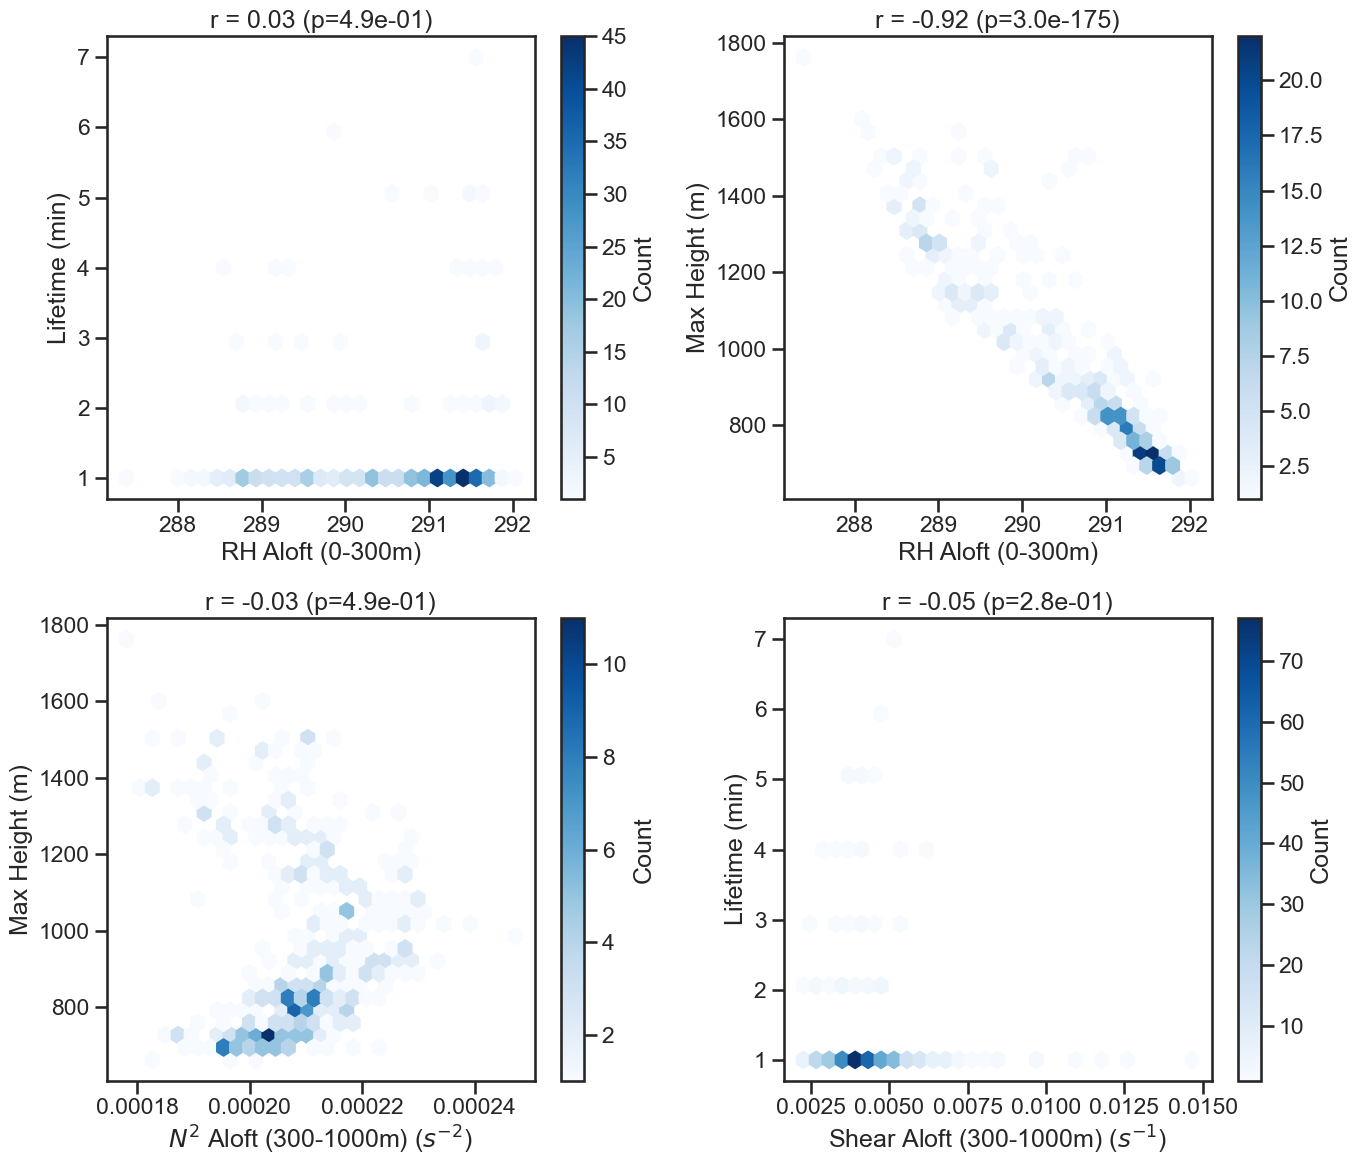

In [ ]:
# --- Plot 3: Simple Layer Indices vs Age / Height ---

# Define layers
# 0-300m
mask_0_300 = (z_above >= 0) & (z_above <= 300)
# 300-1000m
mask_300_1000 = (z_above > 300) & (z_above <= 1000)

# Compute scalar indices
rh_aloft_0_300 = np.nanmean(sel_env_rh[:, mask_0_300], axis=1)
qt_diff_aloft_0_300 = np.nanmean(sel_env_qt[:, mask_0_300], axis=1)
n2_aloft_300_1000 = np.nanmean(sel_env_n2[:, mask_300_1000], axis=1)
shear_aloft_300_1000 = np.nanmean(sel_env_shear[:, mask_300_1000], axis=1)

# Define pairs to plot with physical units
pairs = [
    (rh_aloft_0_300, sel_lifetime_mins, "RH Aloft (0-300m)", "Lifetime (min)"),
    (rh_aloft_0_300, sel_max_height, "RH Aloft (0-300m)", "Max Height (m)"),
    (n2_aloft_300_1000, sel_max_height, "$N^2$ Aloft (300-1000m) ($s^{-2}$)", "Max Height (m)"),
    (shear_aloft_300_1000, sel_lifetime_mins, "Shear Aloft (300-1000m) ($s^{-1}$)", "Lifetime (min)")
]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, (x_data, y_data, x_label, y_label) in enumerate(pairs):
    ax = axes[i]
    
    # Remove NaNs for correlation
    valid = ~np.isnan(x_data) & ~np.isnan(y_data)
    x_clean = x_data[valid]
    y_clean = y_data[valid]
    
    if len(x_clean) > 1:
        corr, p_val = pearsonr(x_clean, y_clean)
        
        # 2D Histogram / Scatter
        # Using hexbin for density
        hb = ax.hexbin(x_clean, y_clean, gridsize=30, cmap='Blues', mincnt=1)
        cb = plt.colorbar(hb, ax=ax)
        cb.set_label('Count')
        
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(f"r = {corr:.2f} (p={p_val:.1e})")
    else:
        ax.text(0.5, 0.5, "Insufficient Data", ha='center', va='center')

plt.tight_layout()
plt.show()

### Correlation Vertical Structure
**Physics:** Vertical sensitivity. Pinpoints the height above cloud top where environmental anomalies most strongly predict lifetime or depth.

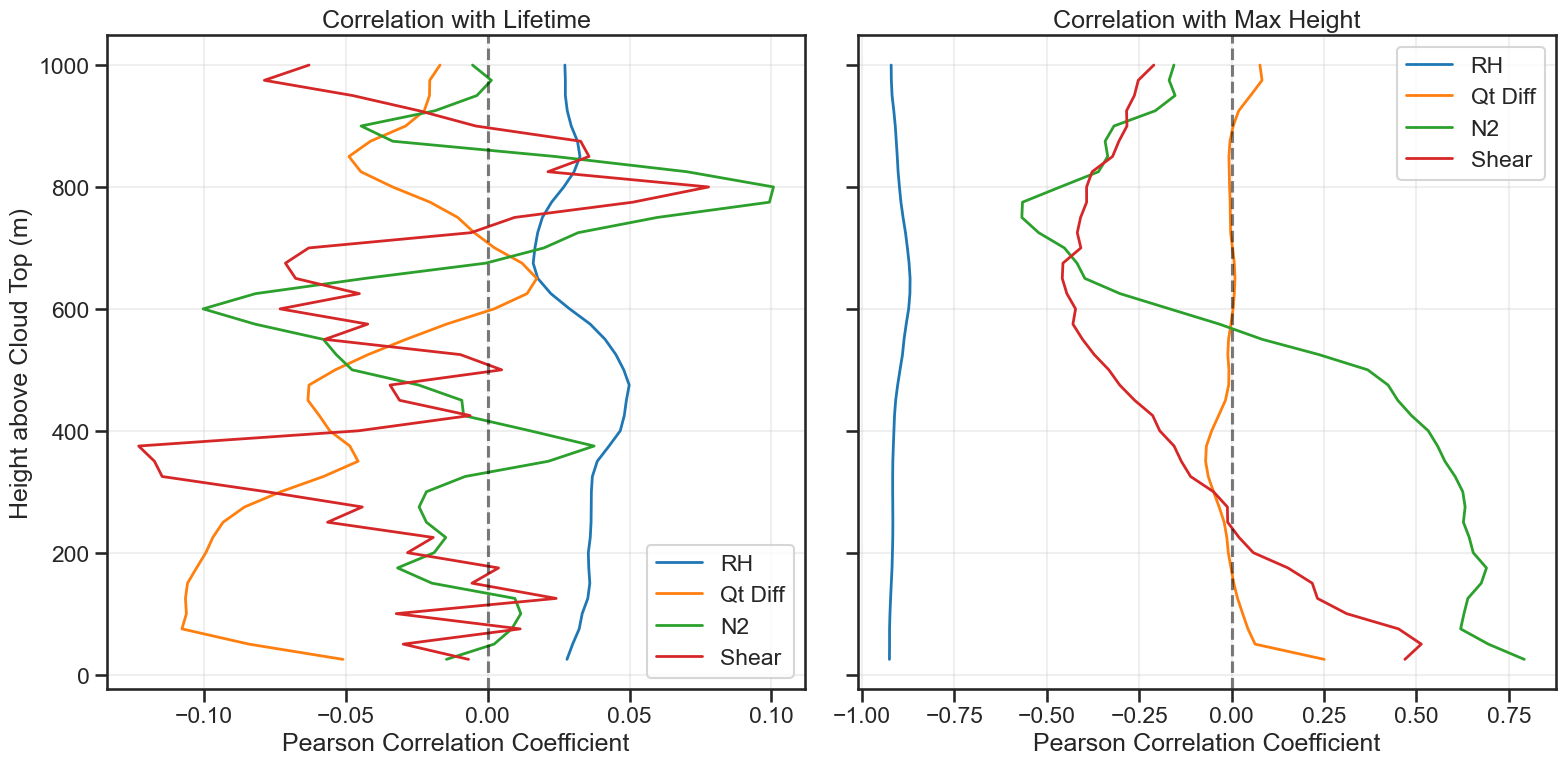

In [ ]:
# --- Plot 4: Correlation vs Height ---

# Compute correlation for each level
def compute_profile_correlation(profile_data, outcome_data):
    corrs = []
    for k in range(profile_data.shape[1]):
        x = profile_data[:, k]
        y = outcome_data
        valid = ~np.isnan(x) & ~np.isnan(y)
        if np.sum(valid) > 2:
            r, _ = pearsonr(x[valid], y[valid])
            corrs.append(r)
        else:
            corrs.append(np.nan)
    return np.array(corrs)

# Correlations with Lifetime
corr_rh_life = compute_profile_correlation(sel_env_rh, sel_lifetime_mins)
corr_qt_life = compute_profile_correlation(sel_env_qt, sel_lifetime_mins)
corr_n2_life = compute_profile_correlation(sel_env_n2, sel_lifetime_mins)
corr_shear_life = compute_profile_correlation(sel_env_shear, sel_lifetime_mins)

# Correlations with Max Height
corr_rh_height = compute_profile_correlation(sel_env_rh, sel_max_height)
corr_qt_height = compute_profile_correlation(sel_env_qt, sel_max_height)
corr_n2_height = compute_profile_correlation(sel_env_n2, sel_max_height)
corr_shear_height = compute_profile_correlation(sel_env_shear, sel_max_height)

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Plot Lifetime Correlations
ax = axes[0]
ax.plot(corr_rh_life, z_above, label='RH', linewidth=2)
ax.plot(corr_qt_life, z_above, label='Qt Diff', linewidth=2)
ax.plot(corr_n2_life, z_above, label='N2', linewidth=2)
ax.plot(corr_shear_life, z_above, label='Shear', linewidth=2)
ax.axvline(0, color='k', linestyle='--', alpha=0.5)
ax.set_title("Correlation with Lifetime")
ax.set_xlabel("Pearson Correlation Coefficient")
ax.set_ylabel("Height above Cloud Top (m)")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot Max Height Correlations
ax = axes[1]
ax.plot(corr_rh_height, z_above, label='RH', linewidth=2)
ax.plot(corr_qt_height, z_above, label='Qt Diff', linewidth=2)
ax.plot(corr_n2_height, z_above, label='N2', linewidth=2)
ax.plot(corr_shear_height, z_above, label='Shear', linewidth=2)
ax.axvline(0, color='k', linestyle='--', alpha=0.5)
ax.set_title("Correlation with Max Height")
ax.set_xlabel("Pearson Correlation Coefficient")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()